# Multiple Linear Regression

#### Build a multilinear regression model on startup company dataset. Identify the attributes that affect the companies profit.

In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Recursive feature elimination
from sklearn.feature_selection import RFE


import statsmodels.formula.api as smf 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import dataset
startup_df = pd.read_csv(r"D:\360digi\DS\Sharath\Multiple_Linear_Regression\handson\Datasets_MLR\50_Startups.csv")
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [4]:
startup_df.rename(columns = {'R&D Spend':'RD_Spend','Marketing Spend':'Marketing_Spend'}, inplace = True)

In [5]:
startup_df.describe()

,RD_Spend,Administration,Marketing_Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [6]:
# check missing values
startup_df.isnull().sum()

RD_Spend           0
Administration     0
Marketing_Spend    0
State              0
Profit             0
dtype: int64

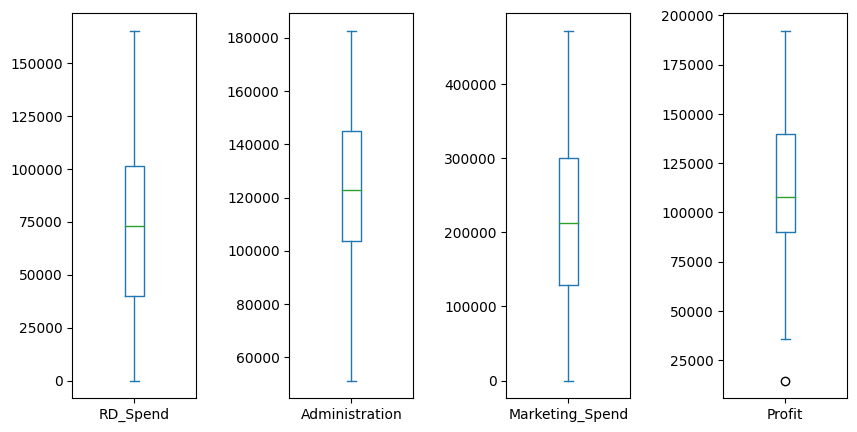

In [7]:
# box plot visualisation
startup_df.plot(kind = 'box', subplots = True, sharey = False, figsize = (10,5))
plt.subplots_adjust(wspace = 0.75)
plt.show()
#outliers in profit column

In [8]:
# Seperating input and output variables 
X = pd.DataFrame(startup_df.iloc[:, 0:4])
Y = pd.DataFrame(startup_df.iloc[:, 4])

 ### Data Preprocessing 

In [9]:
# Select numeric features for data preprocessing
numeric_features = X.select_dtypes(exclude = ['object']).columns
print(numeric_features)

Index(['RD_Spend', 'Administration', 'Marketing_Spend'], dtype='object')


In [10]:
categorical_features = X.select_dtypes(include = ['object']).columns
print(categorical_features)

Index(['State'], dtype='object')


In [11]:
# Winsorization for outlier treatment
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = list(numeric_features))
winsor

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['RD_Spend', 'Administration', 'Marketing_Spend'])

In [12]:
# Missing values Analysis
num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean'))])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer())])

In [13]:
outlier_pipeline = Pipeline(steps = [('winsor', winsor)])
outlier_pipeline

Pipeline(steps=[('winsor',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['RD_Spend', 'Administration',
                                       'Marketing_Spend']))])

In [14]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipeline, numeric_features)])
print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute', SimpleImputer())]),
                                 Index(['RD_Spend', 'Administration', 'Marketing_Spend'], dtype='object'))])


In [15]:
preprocessor1 = ColumnTransformer(transformers = [('wins', outlier_pipeline, numeric_features)])
print(preprocessor1)

ColumnTransformer(transformers=[('wins',
                                 Pipeline(steps=[('winsor',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both',
                                                             variables=['RD_Spend',
                                                                        'Administration',
                                                                        'Marketing_Spend']))]),
                                 Index(['RD_Spend', 'Administration', 'Marketing_Spend'], dtype='object'))])


In [16]:
# Fit the imputation pipeline to input features
imputation = preprocessor.fit(X)

In [17]:
# Transformed data
cleandata = pd.DataFrame(imputation.transform(X), columns = numeric_features)
cleandata.head()


,RD_Spend,Administration,Marketing_Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


In [18]:
clean = preprocessor1.fit(cleandata)
clean

ColumnTransformer(transformers=[('wins',
                                 Pipeline(steps=[('winsor',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both',
                                                             variables=['RD_Spend',
                                                                        'Administration',
                                                                        'Marketing_Spend']))]),
                                 Index(['RD_Spend', 'Administration', 'Marketing_Spend'], dtype='object'))])

In [19]:
cleandata1 = pd.DataFrame(clean.transform(cleandata), columns = numeric_features)
cleandata1.head()

,RD_Spend,Administration,Marketing_Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


In [20]:
## Scaling with MinMaxScaler
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

scale_columntransfer = ColumnTransformer([('scale', scale_pipeline, numeric_features)]) # Skips the transformations for remaining columns

scale = scale_columntransfer.fit(cleandata1)


In [21]:
scaled_data = pd.DataFrame(scale.transform(cleandata1), columns = numeric_features)
scaled_data.describe()

,RD_Spend,Administration,Marketing_Spend
count,50.000000,50.000000,50.000000
mean,0.445854,0.533345,0.447292
std,0.277608,0.213286,0.259208
min,0.000000,0.000000,0.000000
25%,0.241527,0.399260,0.274066
50%,0.441799,0.543661,0.450876
75%,0.614474,0.712221,0.634759
max,1.000000,1.000000,1.000000


In [22]:
X.State.unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [23]:
## Encoding
# Categorical features
encoding_pipeline = Pipeline([('onehot', OneHotEncoder())])

preprocess_pipeline = ColumnTransformer([('categorical', encoding_pipeline, categorical_features)])

clean =  preprocess_pipeline.fit(X)


In [24]:
encode_data = pd.DataFrame(clean.transform(X))

In [25]:
# To get feature names for Categorical columns after Onehotencoding 
encode_data.columns = clean.get_feature_names_out(input_features = X.columns)
encode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   categorical__State_California  50 non-null     float64
 1   categorical__State_Florida     50 non-null     float64
 2   categorical__State_New York    50 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB


In [26]:
clean_data = pd.concat([scaled_data, encode_data], axis = 1)  # concatenated data will have new sequential index
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RD_Spend                       50 non-null     float64
 1   Administration                 50 non-null     float64
 2   Marketing_Spend                50 non-null     float64
 3   categorical__State_California  50 non-null     float64
 4   categorical__State_Florida     50 non-null     float64
 5   categorical__State_New York    50 non-null     float64
dtypes: float64(6)
memory usage: 2.5 KB


In [27]:
clean_data.rename(columns = {'categorical__State_New York':'categorical__State_New_York'}, inplace = True)

In [28]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RD_Spend                       50 non-null     float64
 1   Administration                 50 non-null     float64
 2   Marketing_Spend                50 non-null     float64
 3   categorical__State_California  50 non-null     float64
 4   categorical__State_Florida     50 non-null     float64
 5   categorical__State_New_York    50 non-null     float64
dtypes: float64(6)
memory usage: 2.5 KB


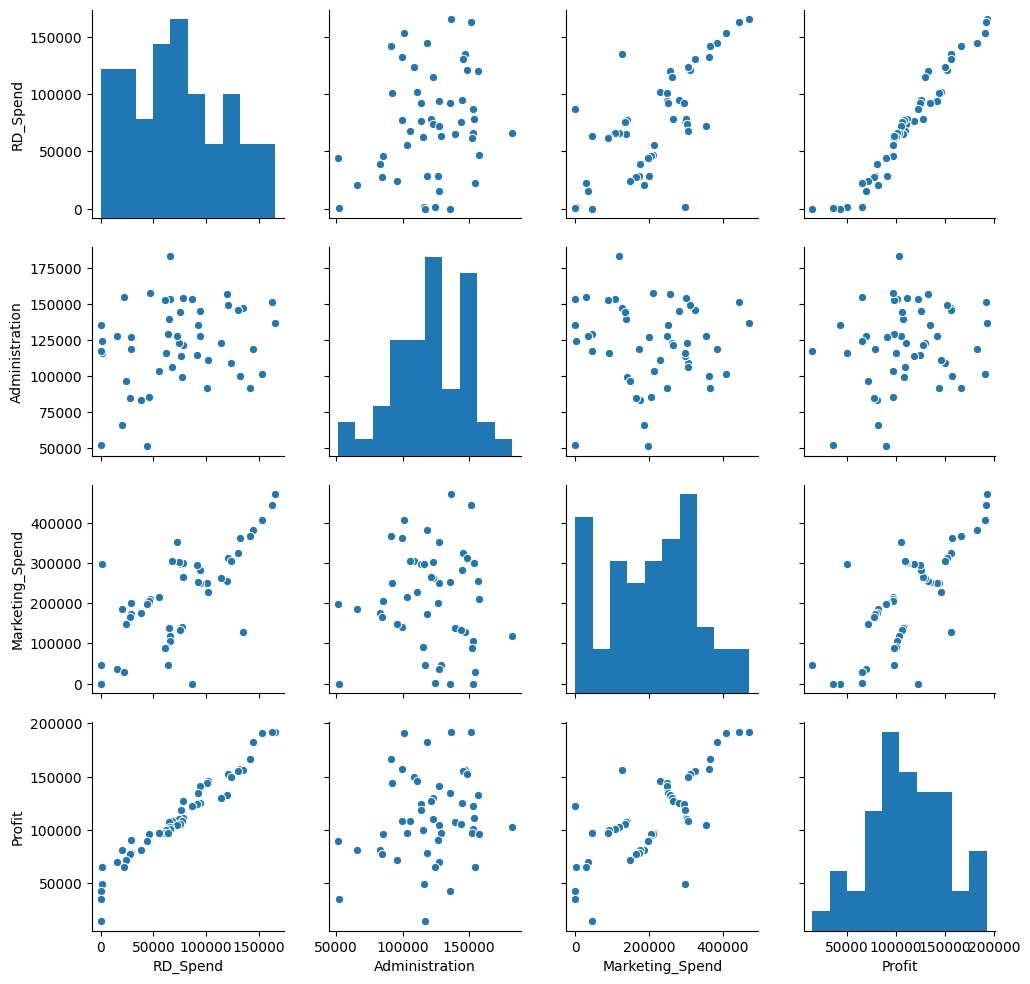

In [29]:
# Multivariate Analysis
sns.pairplot(startup_df) 

In [30]:
# Correlation Analysis on Original Data
orig_df_cor = startup_df.corr()
orig_df_cor

,RD_Spend,Administration,Marketing_Spend,Profit
RD_Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing_Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


In [ ]:
# Collinearity between input pairs observed:
# R&D Spend - Marketing Spend : 0.7242

# R&D Spend - Profit : 0.9729
# Marketing Spend - Profit : 0.7477

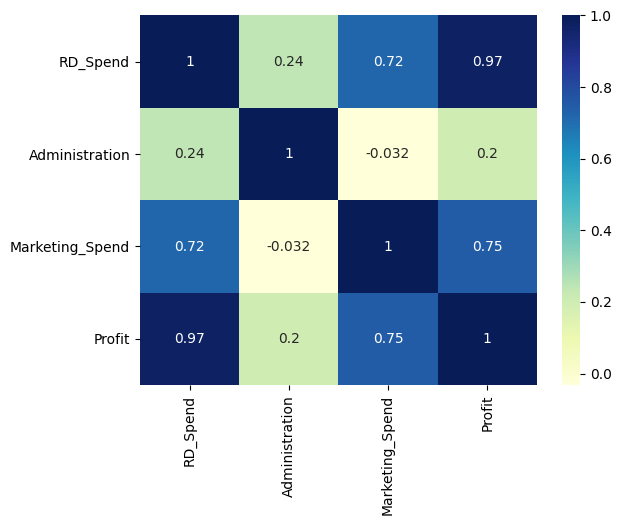

In [31]:
# Heatmap
dataplot = sns.heatmap(orig_df_cor, annot = True, cmap = "YlGnBu")

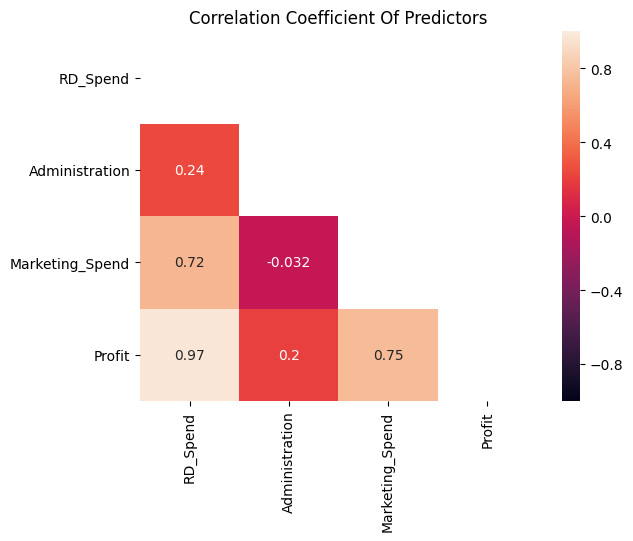

In [32]:
# Upper triangle of an array.
mask = np.triu(np.ones_like(orig_df_cor, dtype = bool))
sns.heatmap(orig_df_cor, annot = True, mask = mask, vmin = -1, vmax = 1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [33]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RD_Spend                       50 non-null     float64
 1   Administration                 50 non-null     float64
 2   Marketing_Spend                50 non-null     float64
 3   categorical__State_California  50 non-null     float64
 4   categorical__State_Florida     50 non-null     float64
 5   categorical__State_New_York    50 non-null     float64
dtypes: float64(6)
memory usage: 2.5 KB


In [34]:
clean_data.describe()

,RD_Spend,Administration,Marketing_Spend,categorical__State_California,categorical__State_Florida,categorical__State_New_York
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.445854,0.533345,0.447292,0.340000,0.320000,0.340000
std,0.277608,0.213286,0.259208,0.478518,0.471212,0.478518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.241527,0.399260,0.274066,0.000000,0.000000,0.000000
50%,0.441799,0.543661,0.450876,0.000000,0.000000,0.000000
75%,0.614474,0.712221,0.634759,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Multiple Linear Regression

In [ ]:
# Build a vanilla model on full dataset
# The intercept is not fit in this 'statsmodel' model so we add a constant value/column

In [35]:
C = add_constant(clean_data)
C.head()

,const,RD_Spend,Administration,Marketing_Spend,categorical__State_California,categorical__State_Florida,categorical__State_New_York
0,1.0,1.000000,0.651744,1.000000,0.0,0.0,1.0
1,1.0,0.983359,0.761972,0.940893,1.0,0.0,0.0
2,1.0,0.927985,0.379579,0.864664,0.0,1.0,0.0
3,1.0,0.873136,0.512998,0.812235,0.0,0.0,1.0
4,1.0,0.859438,0.305328,0.776136,0.0,1.0,0.0


In [36]:
basemodel = sm.OLS(Y, C).fit()
basemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           1.34e-27
Time:                        01:17:52   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          3.659e+04   3354.540     10.909      0.000    2.98e+04    4.34e+04
RD_Spend                       1.333e+05   7673.355     17.369      0.000    1.18e+05    1.49e+05
Administration                -3547.3528   6861.263     -0.517      0.608   -1.74e+04    1.03e+04
Marketing_Spend                1.273e+04   8087.397      1.574      0.123   -3570.409     2.9e+04
categorical__State_California  1.215e+04   2102.952      5.776      0.000    7907.672    1.64e+04
categorical__State_Florida     1.234e+04   2388.628      5.168      0.000    7530.719    1.72e+04
categorical__State_New_York     1.21e+04   2158.898      5.607      0.000    7753.034    1.65e+04
==============================================================================
Omnibus:                       14.782   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.266
Skew:                          -0.948   Prob(JB):                     2.41e-05
Kurtosis:                       5.572   Cond. No.                     4.42e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.25e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
# p > 0.05, will be insignificant
# Administration : 0.608  #high p value can be removed first as part of (Backward elimination)
# Marketing Spend : 0.123

In [ ]:
# R-squared : 0.951
# Prob (F-statistic): 1.34e-27

In [38]:
# Identify the variable with highest collinearity using 'Variance Inflation Factor(VIF)'
# VIF = 1/(1-R*R)
# Assume VIF > 10 = collinearity

vif = pd.Series([variance_inflation_factor(C.values, i) for i in range(C.shape[1])], index = C.columns)
vif

const                            0.000000
RD_Spend                         2.495511
Administration                   1.177766
Marketing_Spend                  2.416797
categorical__State_California         inf
categorical__State_Florida            inf
categorical__State_New_York           inf
dtype: float64

In [ ]:
# col on Index 1 shows highest VIF 
# R&D Spend is showing high VIF value

In [39]:
# Drop colinearity variable - variable 'R&D Spend'
clean_data1 = clean_data.drop('RD_Spend', axis = 1)

In [40]:
clean_data1.columns

Index(['Administration', 'Marketing_Spend', 'categorical__State_California',
       'categorical__State_Florida', 'categorical__State_New_York'],
      dtype='object')

In [41]:
# Build a model on dataset
basemodel2 = sm.OLS(Y, clean_data1).fit()
basemodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     17.83
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           7.78e-09
Time:                        01:18:05   Log-Likelihood:                -576.91
No. Observations:                  50   AIC:                             1164.
Df Residuals:                      45   BIC:                             1173.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Administration                 4.255e+04   1.75e+04      2.426      0.019    7227.804    7.79e+04
Marketing_Spend                1.183e+05   1.48e+04      7.997      0.000    8.85e+04    1.48e+05
categorical__State_California  3.564e+04   1.28e+04      2.793      0.008    9941.619    6.13e+04
categorical__State_Florida     3.394e+04    1.4e+04      2.420      0.020    5691.145    6.22e+04
categorical__State_New_York    3.952e+04   1.32e+04      2.996      0.004    1.29e+04    6.61e+04
==============================================================================
Omnibus:                        5.729   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.349
Skew:                          -0.461   Prob(JB):                       0.0689
Kurtosis:                       4.311   Cond. No.                         6.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# R-squared: 0.613 reducesd significantly

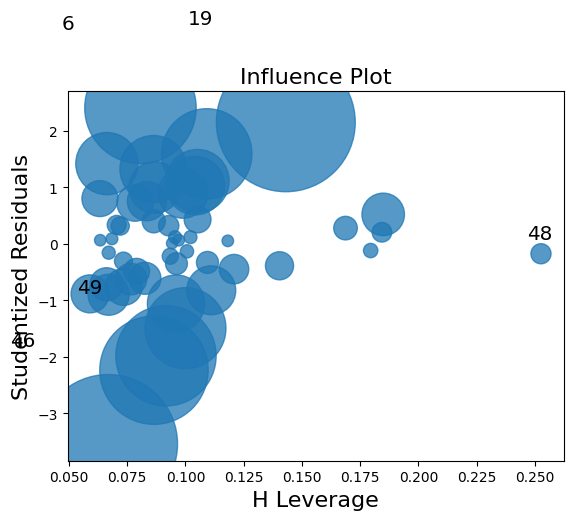

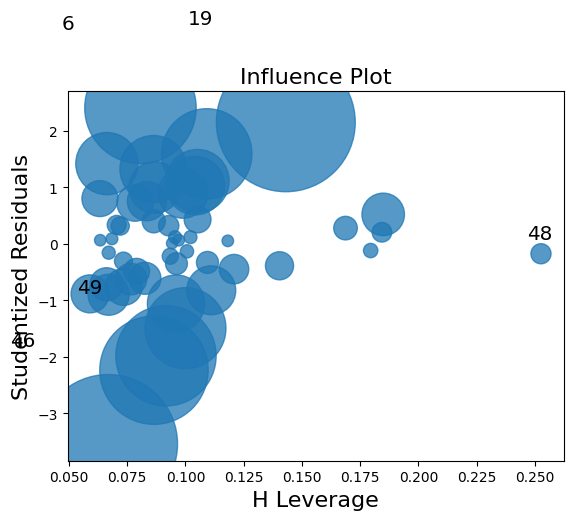

In [43]:
sm.graphics.influence_plot(basemodel2, size=100, plot_alpha=0.75)

In [44]:
# Remove few influential observations to tune the model and verify 
clean_data1_new = clean_data1.drop(clean_data1.index[[6, 19]])
Y_new = Y.drop(Y.index[[6, 19]])

In [45]:
# Build model on new dataset
basemodel3 = sm.OLS(Y_new, clean_data1_new).fit()
basemodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     23.95
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           1.81e-10
Time:                        01:18:12   Log-Likelihood:                -548.83
No. Observations:                  48   AIC:                             1108.
Df Residuals:                      43   BIC:                             1117.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Administration                 3.044e+04   1.62e+04      1.877      0.067   -2265.060    6.32e+04
Marketing_Spend                1.288e+05   1.38e+04      9.313      0.000    1.01e+05    1.57e+05
categorical__State_California  3.414e+04   1.15e+04      2.959      0.005    1.09e+04    5.74e+04
categorical__State_Florida      3.49e+04   1.27e+04      2.750      0.009    9305.504    6.05e+04
categorical__State_New_York    3.779e+04    1.2e+04      3.138      0.003    1.35e+04    6.21e+04
==============================================================================
Omnibus:                       15.694   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.990
Skew:                          -1.125   Prob(JB):                     4.56e-05
Kurtosis:                       5.221   Cond. No.                         6.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
clean_data1_new.describe()

,Administration,Marketing_Spend,categorical__State_California,categorical__State_Florida,categorical__State_New_York
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.524143,0.460289,0.333333,0.333333,0.333333
std,0.212697,0.254863,0.476393,0.476393,0.476393
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.390495,0.290354,0.000000,0.000000,0.000000
50%,0.539150,0.470338,0.000000,0.000000,0.000000
75%,0.680680,0.637225,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
# Splitting data into training and testing data set
X_train, X_test, Y_train, Y_test = train_test_split(clean_data1_new, Y_new, test_size = 0.2, random_state = 0) 

In [48]:
## Build the best model Model building with out cv
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     19.63
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           2.37e-08
Time:                        01:18:17   Log-Likelihood:                -435.62
No. Observations:                  38   AIC:                             881.2
Df Residuals:                      33   BIC:                             889.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Administration                 3.288e+04   2.06e+04      1.596      0.120   -9029.702    7.48e+04
Marketing_Spend                1.294e+05   1.57e+04      8.249      0.000    9.75e+04    1.61e+05
categorical__State_California  3.043e+04   1.42e+04      2.141      0.040    1517.952    5.93e+04
categorical__State_Florida      3.25e+04   1.43e+04      2.271      0.030    3385.310    6.16e+04
categorical__State_New_York      3.5e+04   1.33e+04      2.631      0.013    7938.101    6.21e+04
==============================================================================
Omnibus:                       15.960   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.337
Skew:                          -1.292   Prob(JB):                     6.32e-05
Kurtosis:                       5.353   Cond. No.                         6.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# R-squared: 0.704

In [50]:
# Predicting upon X_train
ytrain_pred = model.predict(X_train)
r_squared_train = r2_score(Y_train, ytrain_pred)
r_squared_train

0.7040926347085883

In [51]:
# Train residual values
train_resid  = Y_train.Profit - ytrain_pred
# RMSE value for train data 
train_rmse = np.sqrt(np.mean(train_resid * train_resid))
train_rmse

23032.992352155412

In [52]:
# Predicting upon X_test
y_pred = model.predict(X_test)

In [53]:
# checking the Accurarcy by using r2_score
r_squared = r2_score(Y_test, y_pred)
r_squared

0.5749964724280194

In [54]:
# Test residual values
test_resid  = Y_test.Profit - y_pred
# RMSE value for train data 
test_rmse = np.sqrt(np.mean(test_resid * test_resid))
test_rmse


19928.130506201014

In [55]:
## Scores with Cross Validation (cv)
# k-fold CV (using all variables)
lm = LinearRegression()

In [56]:
## Scores with KFold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

scores = cross_val_score(lm, X_train, Y_train, scoring = 'r2', cv = folds)
scores 

array([-0.13134624,  0.73611866,  0.62180541,  0.85641282,  0.35145468])

In [57]:
## Model building with CV and RFE

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [58]:
# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 6))}]

In [59]:
# step-3: perform grid search
# 3.1 specify model
# lm = LinearRegression()
lm.fit(X_train, Y_train)


LinearRegression()

In [60]:
# Recursive feature elimination
rfe = RFE(lm)

In [61]:
# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring = 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score = True) 

In [62]:
# fit the model
model_cv.fit(X_train, Y_train) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5]}],
             return_train_score=True, scoring='r2', verbose=1)

In [63]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006998,0.001981,0.003787,0.001468,1,{'n_features_to_select': 1},0.359949,0.836423,0.672341,0.739388,...,0.627036,0.167240,2,0.767229,0.620761,0.673779,0.672622,0.672995,0.681477,0.047433
1,0.003975,0.000014,0.002201,0.000396,2,{'n_features_to_select': 2},0.359331,0.834530,0.673783,0.900221,...,0.677185,0.189231,1,0.768010,0.620989,0.701967,0.680215,0.689048,0.692046,0.047047
2,0.003398,0.000494,0.002103,0.000473,3,{'n_features_to_select': 3},0.355620,0.835749,0.620196,0.860242,...,0.610075,0.215387,3,0.768170,0.621070,0.711226,0.683937,0.700817,0.697044,0.047367
3,0.002999,0.000011,0.002215,0.000377,4,{'n_features_to_select': 4},0.355620,0.835749,0.621805,0.856413,...,0.604208,0.220549,4,0.768170,0.621070,0.712002,0.683955,0.701433,0.697326,0.047423
4,0.002614,0.000493,0.001988,0.000013,5,{'n_features_to_select': 5},-0.131346,0.736119,0.621805,0.856413,...,0.486889,0.351404,5,-0.002292,0.660079,0.712002,0.683955,0.701433,0.551035,0.277221


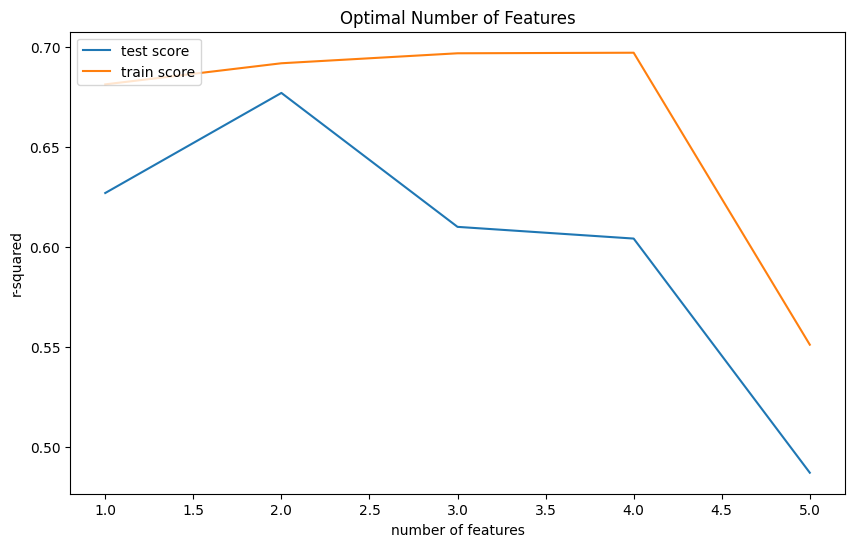

In [64]:
# plotting cv results
plt.figure(figsize = (10, 6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc = 'upper left')

# train and test scores get stable after 2rd feature. 
# we can select number of optimal features more than 2

In [65]:
model_cv.best_params_

{'n_features_to_select': 2}

In [66]:
cv_lm_grid = model_cv.best_estimator_
cv_lm_grid

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [ ]:
# Model gives best result when we consider 2 features.

In [67]:
rfe_3 = RFE(lm,n_features_to_select=2)

In [68]:
rfe_3 = rfe_3.fit(X_train,Y_train)

In [69]:
rfe_3.support_

array([False,  True, False, False,  True])

In [70]:
rfe_3.ranking_ 

array([4, 1, 2, 3, 1])

In [71]:
rfe_3.feature_names_in_

array(['Administration', 'Marketing_Spend',
       'categorical__State_California', 'categorical__State_Florida',
       'categorical__State_New_York'], dtype=object)

In [72]:
rfe_3.feature_names_in_[rfe_3.support_]

array(['Marketing_Spend', 'categorical__State_New_York'], dtype=object)

In [ ]:
# Consider the columns after recursive feature elimination and test the model
# Select the best features and build the model

In [73]:
X_new = clean_data.loc[:,['Marketing_Spend', 'categorical__State_New_York']]
X_new.shape

(50, 2)

In [74]:
Y1 = pd.DataFrame(startup_df.iloc[:, 4])
Y1.shape

(50, 1)

In [75]:
# Build model on new dataset
basemodel4 = sm.OLS(Y1, X_new).fit()
basemodel4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Profit   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              213.7
Date:                Wed, 01 Mar 2023   Prob (F-statistic):                    1.26e-24
Time:                        01:20:09   Log-Likelihood:                         -597.93
No. Observations:                  50   AIC:                                      1200.
Df Residuals:                      48   BIC:                                      1204.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Marketing_Spend              2.031e+05   1.21e+04     16.716      0.000    1.79e+05    2.28e+05
categorical__State_New_York  2.536e+04   1.07e+04      2.360      0.022    3755.458     4.7e+04
==============================================================================
Omnibus:                        1.682   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                0.882
Skew:                           0.044   Prob(JB):                        0.643
Kurtosis:                       3.645   Cond. No.                         1.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# R-squared (uncentered): 0.899 , where |r| > 0.85 is considered as strong correlation

In [ ]:
# According to the above model summary : 'Marketing_Spend', 'categorical__State_New_York' 
# are the two attributes that can be considered to understand the company 
# is able to make profit or not.

In [76]:
# Prediction
pred = basemodel4.predict(X_new)

In [77]:
test_resid = pred - Y1.Profit

In [78]:
# RMSE value
test_rmse = np.sqrt(np.mean(test_resid * test_resid))
test_rmse

37785.09390131743

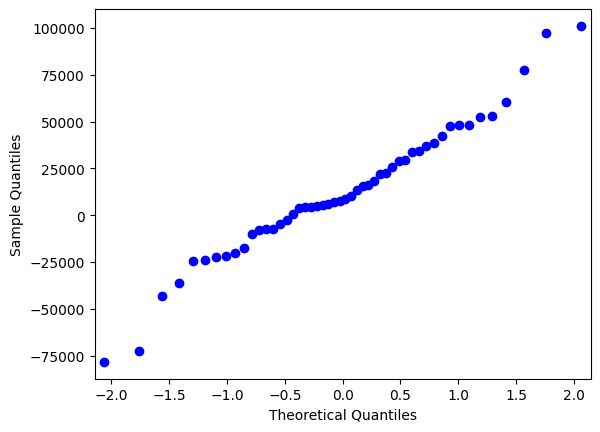

In [79]:
res = basemodel4.resid
sm.qqplot(res)
plt.show()

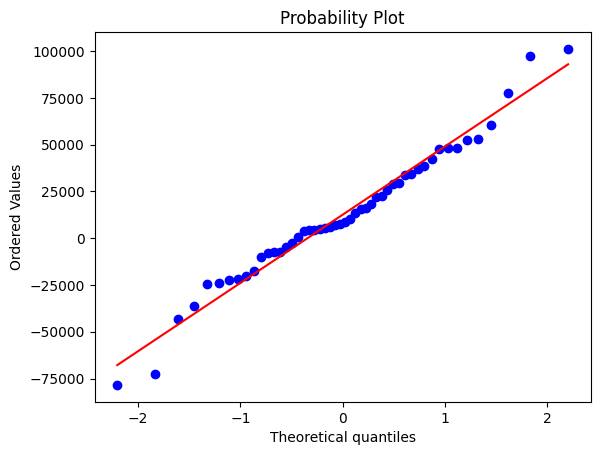

In [80]:
# Q-Q plot
from scipy import stats
import pylab
stats.probplot(res, dist = "norm", plot = pylab)
plt.show()

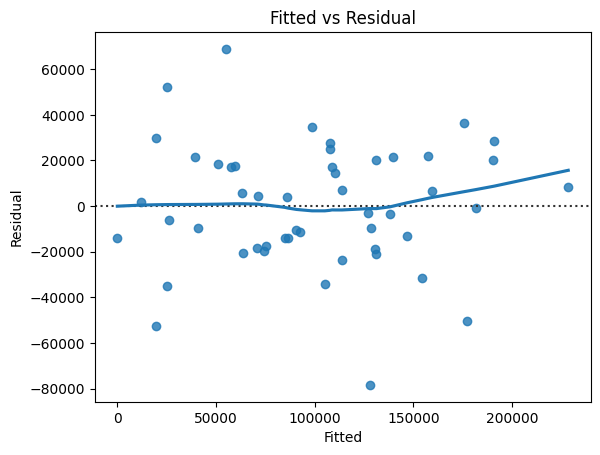

In [81]:
# Residuals vs Fitted plot
sns.residplot(x = pred, y = Y1.Profit, lowess = True)
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.title('Fitted vs Residual')
plt.show()